# Fine-Tuning Vision Transformers for Image Classification



### Install Libraries

In [ ]:
! pip install datasets transformers
!pip install accelerate>=0.21.0
!pip install wandb

### LOGIN WANDDB

In [20]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Authenticate Gdrive if you have data in Gdrive

In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

Click on the link to authenticate

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

## Load a dataset

Let's start by loading a small image classification dataset and taking a look at its structure.

We'll use the weather dataset from kaggle, which is a collection of pictures of different wheather's.

In [5]:
from datasets import load_dataset

ds = load_dataset("imagefolder", data_dir = "datasets/wheather_dataset")
print(ds['train'].column_names)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['image', 'label']


#### Convert images to 3 channels RGB

In [7]:
from PIL import Image

def convert_image_to_rgb(example):
    example['image'] = example['image'].convert('RGB')
    return example

ds = ds.map(convert_image_to_rgb)

Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 679/679 [01:00<00:00, 11.22 examples/s]


Let's take a look at the 100th example from the `'train'` split from the weather dataset. You'll notice each example from the dataset has 3 features:

1. `image`: A PIL Image
1. `image_file_path`: The `str` path to the image file that was loaded as `image`
1. `labels`: A [`datasets.ClassLabel`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel) feature, which we'll see as an integer representation of the label for a given example. (Later we'll see how to get the string class names, don't worry)

In [21]:
ex = ds['train'][100]
ex

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=400x265>,
 'label': 0}

Let's take a look at the image 👀

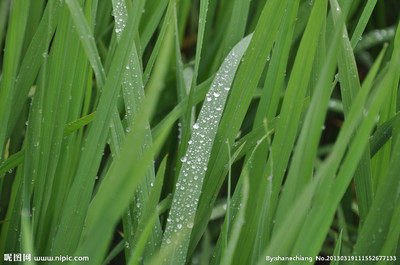

In [22]:
image = ex['image']
image

### Find out the labels of the datasets

In [10]:
labels = ds["train"].features["label"].names
labels

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

### Let's write a function that'll display a grid of examples from each class to get a better idea of what you're working with.

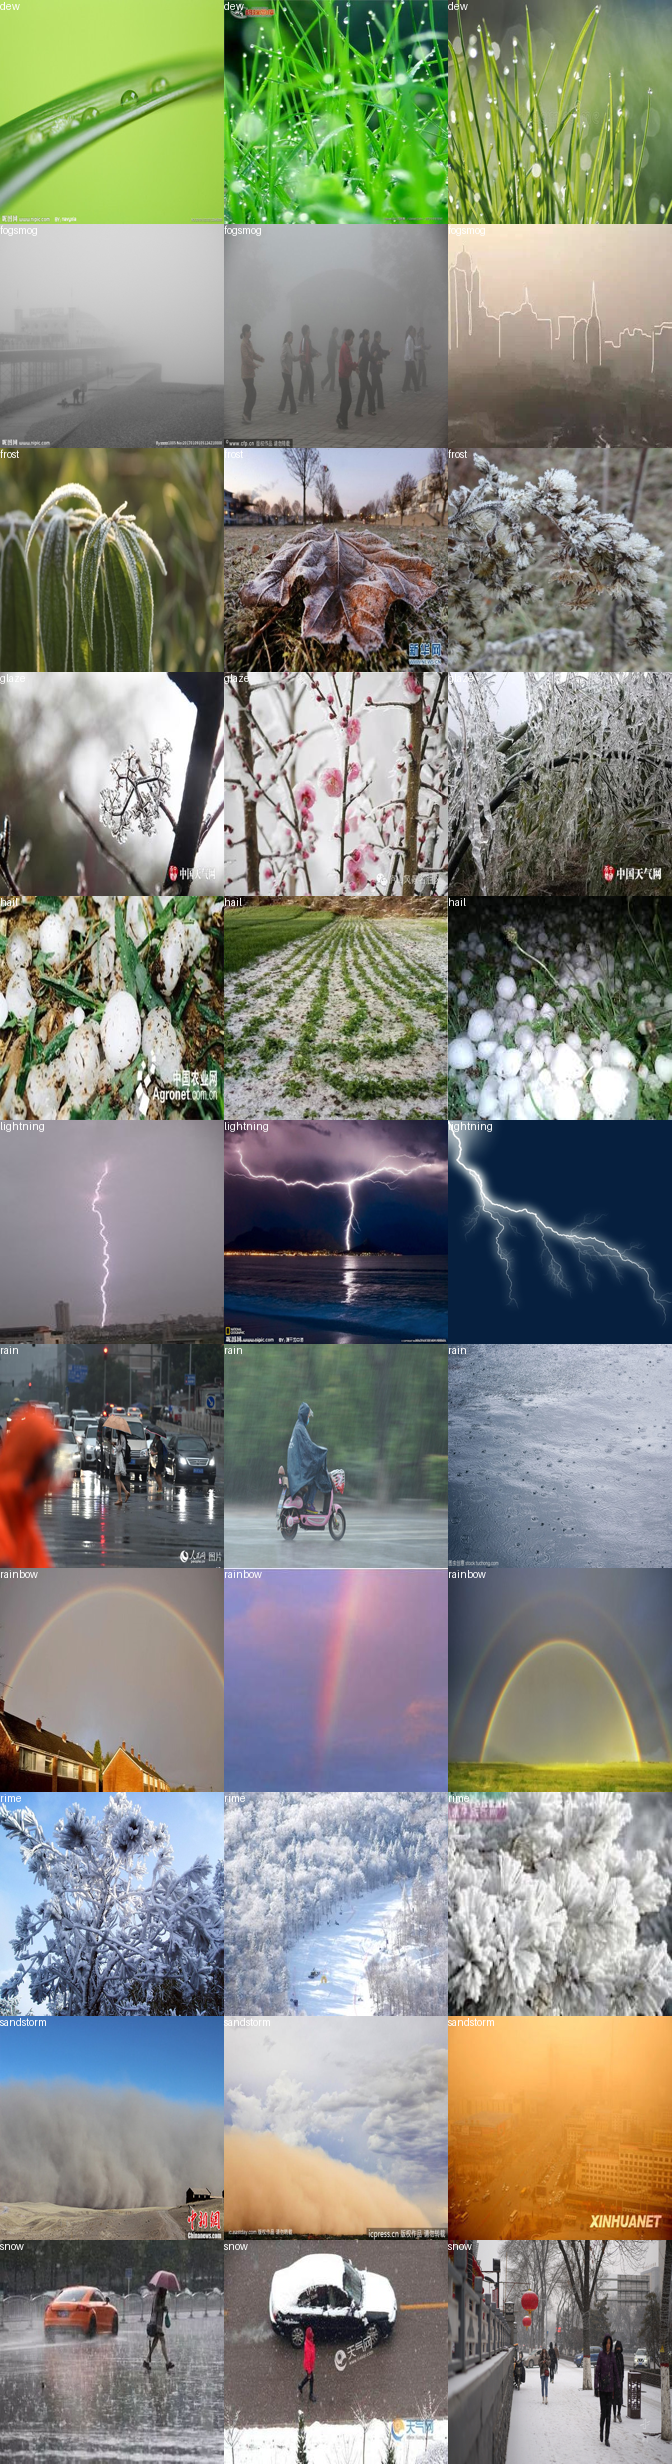

In [23]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(224, 224)):
    labels = ds['train'].features['label'].names
    w, h = size
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255))

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

## Loading ViT Feature Extractor

Now that we know what our images look like and have a better understanding of the problem we're trying to solve, let's see how we can prepare these images for our model.

When ViT models are trained, specific transformations are applied to images being fed into them. Use the wrong transformations on your image and the model won't be able to understand what it's seeing! 🖼 ➡️ 🔢

To make sure we apply the correct transformations, we will use a [`ViTFeatureExtractor`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) model, so lets load its feature extractor from the 🤗 Hub.

In [24]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


If we print a feature extractor, we can see its configuration.

In [25]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing `pixel values`, which is the numeric representation of your image that we'll pass to the model.

We get a numpy array by default, but if we add the `return_tensors='pt'` argument, we'll get back `torch` tensors instead.


In [26]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-0.5059, -0.3882, -0.3333,  ..., -0.8039, -0.8118, -0.7882],
          [-0.4824, -0.3647, -0.3098,  ..., -0.7961, -0.8039, -0.7882],
          [-0.4510, -0.3412, -0.2784,  ..., -0.7961, -0.7961, -0.7882],
          ...,
          [-0.6784, -0.7569, -0.7882,  ..., -0.6627, -0.6314, -0.6627],
          [-0.6706, -0.7569, -0.7333,  ..., -0.6863, -0.6392, -0.6627],
          [-0.7098, -0.7490, -0.7569,  ..., -0.6863, -0.6549, -0.6627]],

         [[-0.2706, -0.1608, -0.1137,  ..., -0.6941, -0.7333, -0.7490],
          [-0.2471, -0.1373, -0.0980,  ..., -0.6941, -0.7255, -0.7412],
          [-0.2157, -0.1059, -0.0667,  ..., -0.6941, -0.7176, -0.7333],
          ...,
          [-0.4510, -0.5294, -0.6078,  ..., -0.4275, -0.4275, -0.4510],
          [-0.4824, -0.5529, -0.5608,  ..., -0.4275, -0.4353, -0.4510],
          [-0.4980, -0.5529, -0.5765,  ..., -0.4431, -0.4431, -0.4667]],

         [[-0.6941, -0.5608, -0.4745,  ..., -0.8745, -0.8745, -0.8510],
          [-0

## Processing the Dataset

Now that we know how to read in images and transform them into inputs, let's write a function that will put those two things together to process a single example from the dataset.

In [27]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['label']
    return inputs

In [28]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.4431, -0.4275, -0.4039,  ..., -0.3020, -0.0510, -0.0745],
          [-0.4353, -0.4196, -0.3882,  ..., -0.4510, -0.2157, -0.0431],
          [-0.4275, -0.3961, -0.3804,  ..., -0.5373, -0.4039, -0.2471],
          ...,
          [-0.9765, -0.9529, -0.5922,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -0.9843, -0.9843,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[ 0.2706,  0.2706,  0.2863,  ...,  0.3255,  0.2157, -0.0118],
          [ 0.2627,  0.2706,  0.2863,  ...,  0.2471,  0.2157,  0.2314],
          [ 0.2549,  0.2706,  0.2784,  ...,  0.2549,  0.2549,  0.3020],
          ...,
          [-0.9765, -0.9529, -0.5922,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -0.9843, -0.9843,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-0.4588, -0.4275, -0.3725,  ..., -0.8353, -0.7569, -0.8824],
          [-0

While we could call `ds.map` and apply this to every example at once, this can be very slow, especially if you use a larger dataset. Instead, we'll apply a ***transform*** to the dataset. Transforms are only applied to examples as you index them.

First, though, we'll need to update our last function to accept a batch of data, as that's what `ds.with_transform` expects.

In [29]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')
    inputs['labels'] = example_batch['label']
    return inputs

We can directly apply this to our dataset using `ds.with_transform(transform)`.

In [30]:
prepared_ds = ds.with_transform(transform)

Now, whenever we get an example from the dataset, our transform will be
applied in real time (on both samples and slices, as shown below)

In [31]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.4431, -0.4275, -0.4039,  ..., -0.3020, -0.0510, -0.0745],
          [-0.4353, -0.4196, -0.3882,  ..., -0.4510, -0.2157, -0.0431],
          [-0.4275, -0.3961, -0.3804,  ..., -0.5373, -0.4039, -0.2471],
          ...,
          [-0.9765, -0.9529, -0.5922,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -0.9843, -0.9843,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[ 0.2706,  0.2706,  0.2863,  ...,  0.3255,  0.2157, -0.0118],
          [ 0.2627,  0.2706,  0.2863,  ...,  0.2471,  0.2157,  0.2314],
          [ 0.2549,  0.2706,  0.2784,  ...,  0.2549,  0.2549,  0.3020],
          ...,
          [-0.9765, -0.9529, -0.5922,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -0.9843, -0.9843,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-0.4588, -0.4275, -0.3725,  ..., -0.8353, -0.7569, -0.8824],
          [-0

# Training and Evaluation

The data is processed and we are ready to start setting up the training pipeline. We will make use of 🤗's Trainer, but that'll require us to do a few things first:

- Define a collate function.

- Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. We should define a compute_metrics function accordingly.

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify our images.

### Define our data collator

Batches are coming in as lists of dicts, so we just unpack + stack those into batch tensors.

We return a batch `dict` from our `collate_fn` so we can simply `**unpack` the inputs to our model later. ✨

In [32]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Define an evaluation metric

Here, we load the [accuracy](https://huggingface.co/metrics/accuracy) metric from `datasets`, and then write a function that takes in a model prediction + computes the accuracy.

In [33]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/tmp/ipykernel_3447/2425197347.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Now we can load our pretrained model. We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels in the 🤗 hub widget if we choose to `push_to_hub`.

In [34]:
from transformers import ViTForImageClassification

labels = ds['train'].features['label'].names
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We're almost ready to train! The last thing we'll do before that is set up the training configuration by defining [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments).

Most of these are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually its ideal to drop unused feature columns, as it makes it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set `remove_unused_columns=False`.

In [39]:
wandb.init(
    # set the wandb project where this run will be logged
    project="VIT-FINETUNE-WEATHER",
    config={
    "learning_rate": 2e-3,
    "architecture": "TRANSFORMER",
    "dataset": "WEATHER",
    "epochs": 4,
    }
)

In [40]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-whether-demo-v1",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to="wandb",
  load_best_model_at_end=True,
)

Now, all instances can be passed to Trainer and we are ready to start training!



In [41]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [42]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1398479479GF
  train_loss               =       0.1985
  train_runtime            =   0:09:05.68
  train_samples_per_second =       35.507
  train_steps_per_second   =        2.221


In [43]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9367
  eval_loss               =     0.2501
  eval_runtime            = 0:00:07.90
  eval_samples_per_second =     85.942
  eval_steps_per_second   =     10.759


In [44]:
from PIL import Image
import torch

# Load an image
image = Image.open('datasets/wheather_dataset/test/glaze/6107.jpg').convert('RGB')

# Preprocess the image using the feature_extractor used during training
inputs = feature_extractor(images=image, return_tensors="pt")

# Move your inputs to the same device as your model
inputs = {k: v.to(trainer.args.device) for k, v in inputs.items()}

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits.argmax(-1)

# Convert predictions to labels if necessary
predicted_labels = [pred for pred in predictions.cpu().numpy()]

print(labels[predicted_labels[0]])


glaze
